In [1]:
cd C:/Users/KimMinwoo/Documents/BigContest

C:\Users\KimMinwoo\Documents\BigContest


In [2]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np

#test and score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, RobustScaler

import random as rd
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from collections import Counter
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:190: DeprecationWarning: invalid escape sequence \S
  """
C:\ProgramData\Anaconda3\lib\site-packages\nose\config.py:178: DeprecationWarning: invalid escape sequence \.
  """


In [4]:
#(9/27 변수디풀트 +(신용카드,신용등급 one-hot 인코딩))
Train = pd.read_csv("final.csv",encoding='EUC-KR') 

In [5]:
#위에서 Nan을 포함하는 변수 지워주기
Train = Train.drop(labels=(["CHLD_AGE_10s","CHLD_AGE_29s","YEAR08-09_@"]),axis=1)
#위에서 Inf을 포함하는 변수 지워주기
Train = Train.drop(labels=(["RATIO_30OVDU_RATE"]),axis=1)

In [6]:
X = Train.drop("TARGET",axis=1)
X = X.drop("CUST_ID",axis=1)
Y = Train["TARGET"]


In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.3)

In [8]:
#랜덤오버샘플링
ros = RandomOverSampler(random_state=0)
X_train, Y_train = ros.fit_sample(X_train, Y_train)
X_train= pd.DataFrame(X_train)
X_train.columns = X_val.columns.copy()

In [9]:
#f1_score 만들기
def xgb_f1(y,t):
    t = t.get_label()
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in y] # binaryzing your output
    return 'f1',f1_score(t,y_bin)

#Xgboost Matrix
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_val, label=Y_val)



In [10]:
param = {'max_depth':12, 'eta':0.01, 'silent':0, 'objective':'binary:logistic',
        'gamma':0.3,'min_child_weight':1, 'max_delta_step':0, 'subsample':0.95,
                            'colsample_bytree':0.55,'reg_alpha':5e-05}
num_round = 2340
bst = xgb.train(param, dtrain, num_round,feval=xgb_f1)

In [11]:
asd = bst.predict(dtest,output_margin=False, ntree_limit=0, pred_leaf=False, pred_contribs=False)

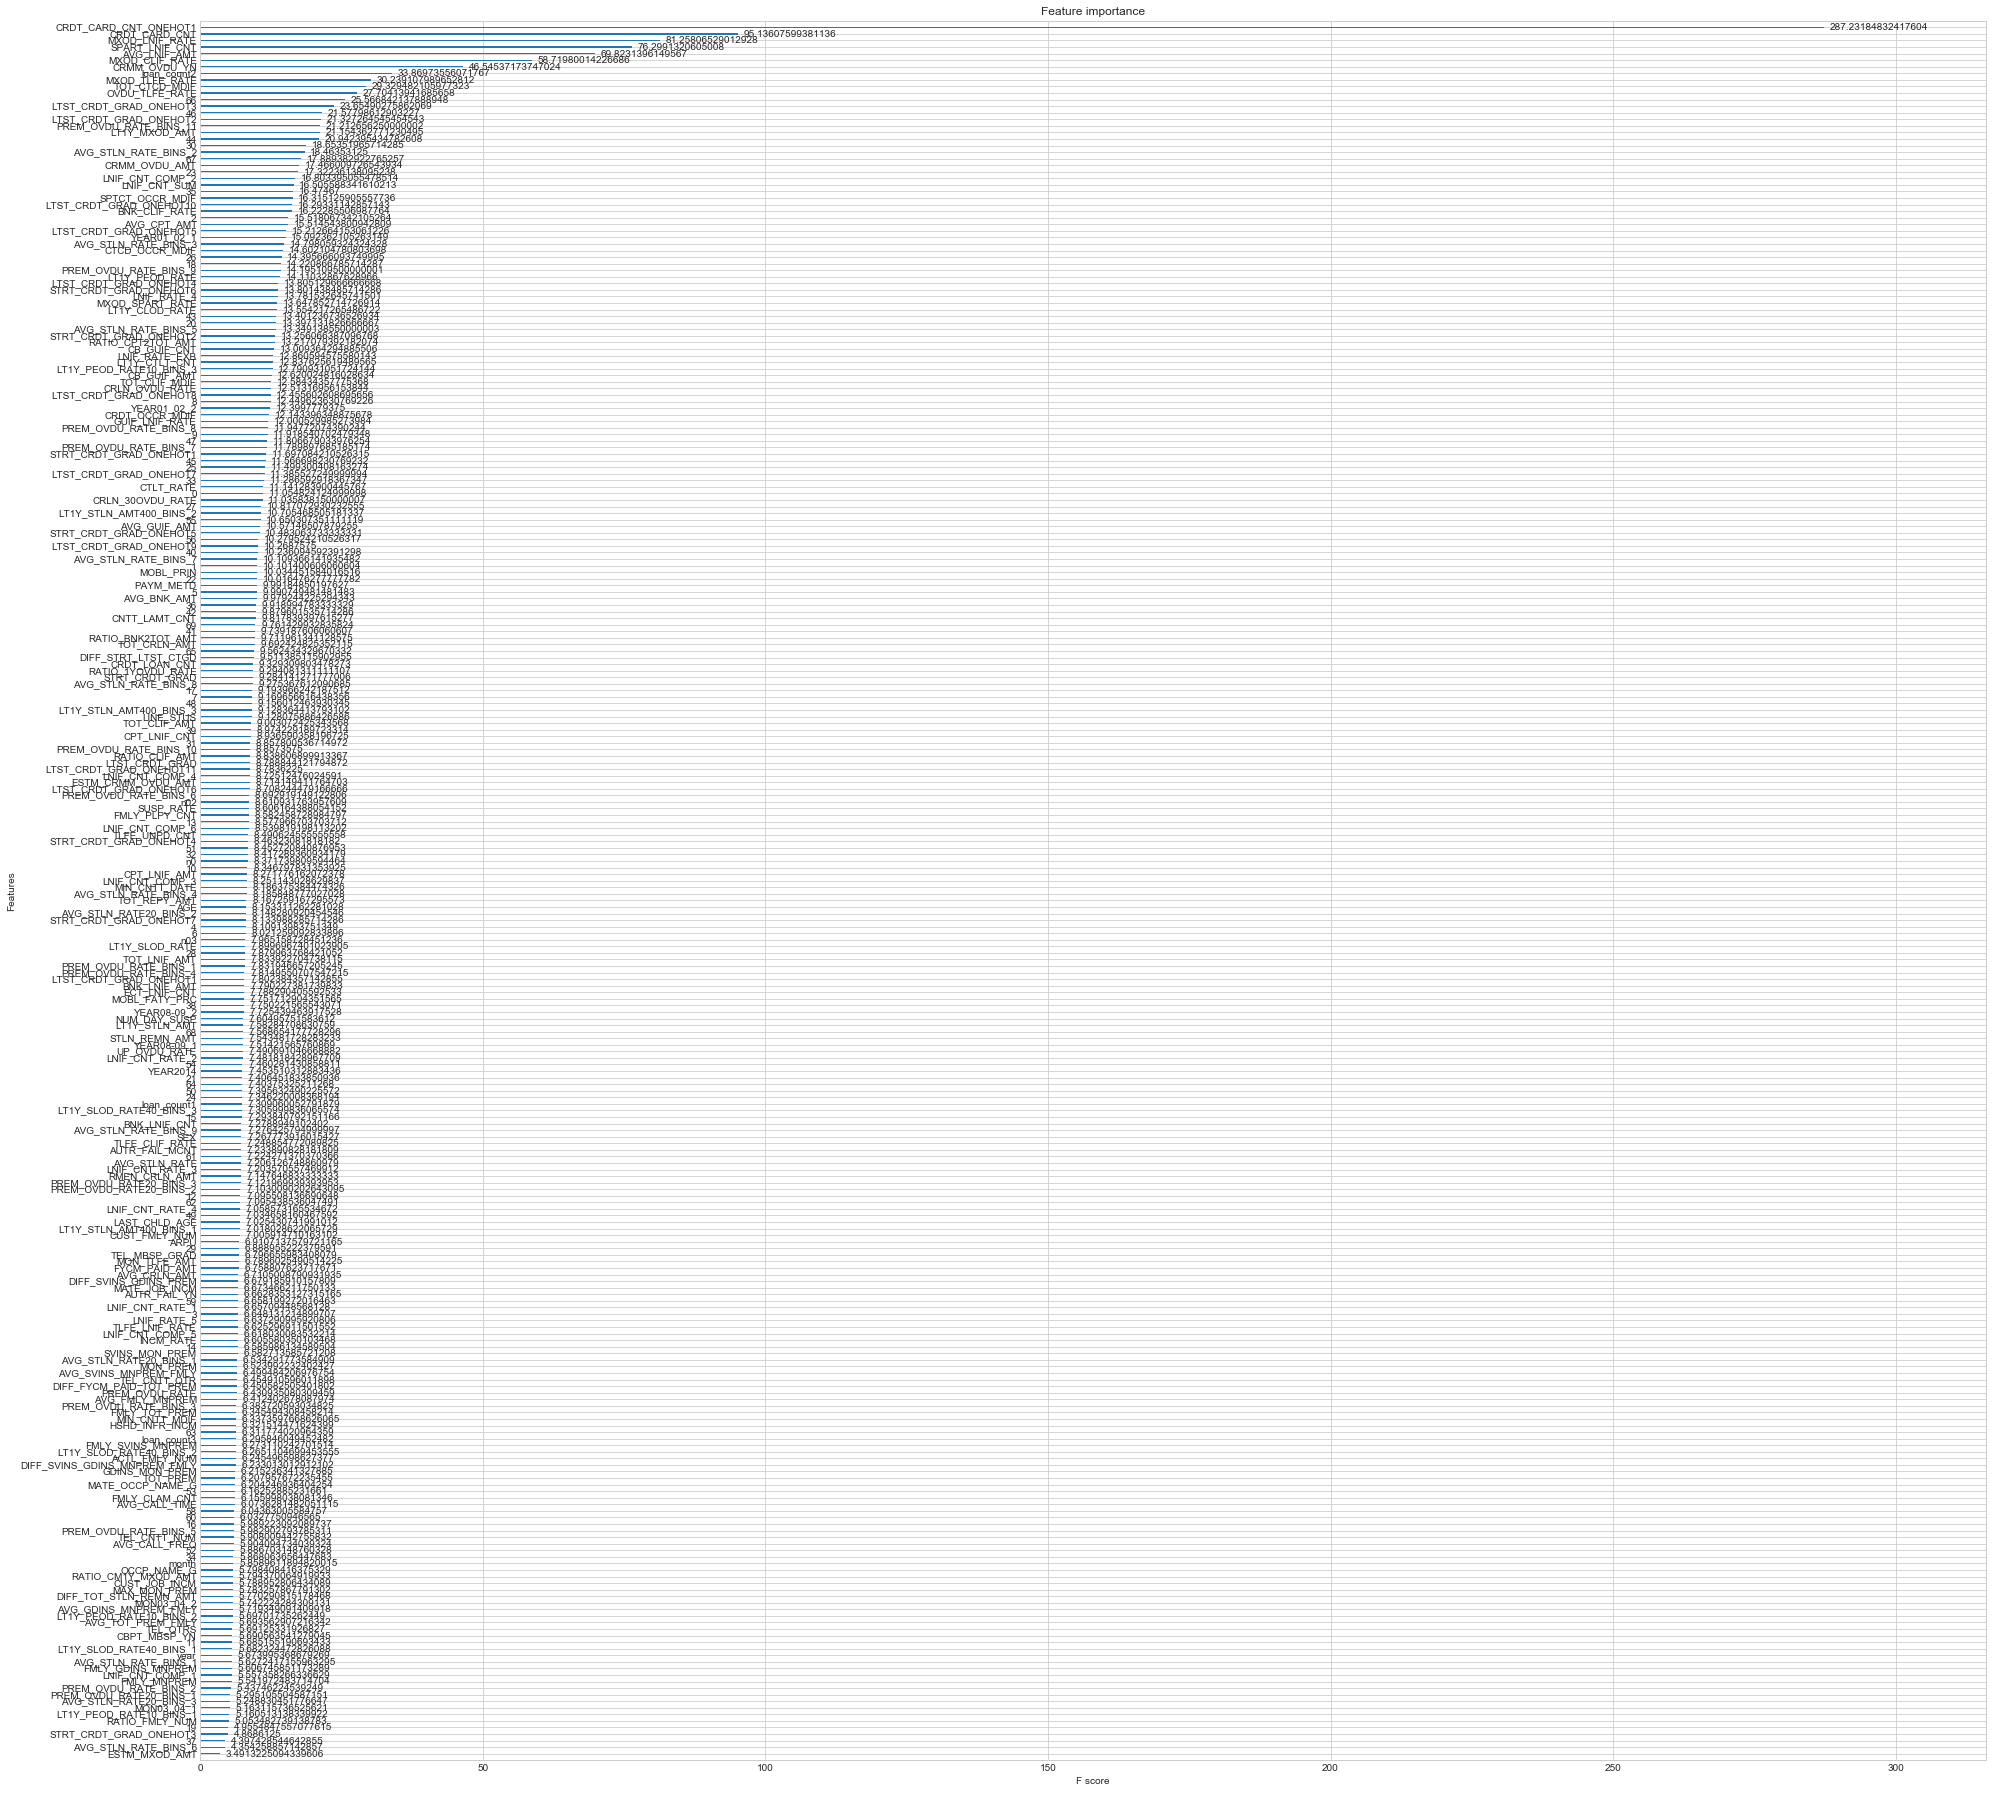

In [14]:
ax = xgb.plot_importance(bst,importance_type="gain")
fig = ax.figure
fig.set_size_inches(32, 32)

In [22]:
xgb.plot_importance(bst,importance_type="gain")

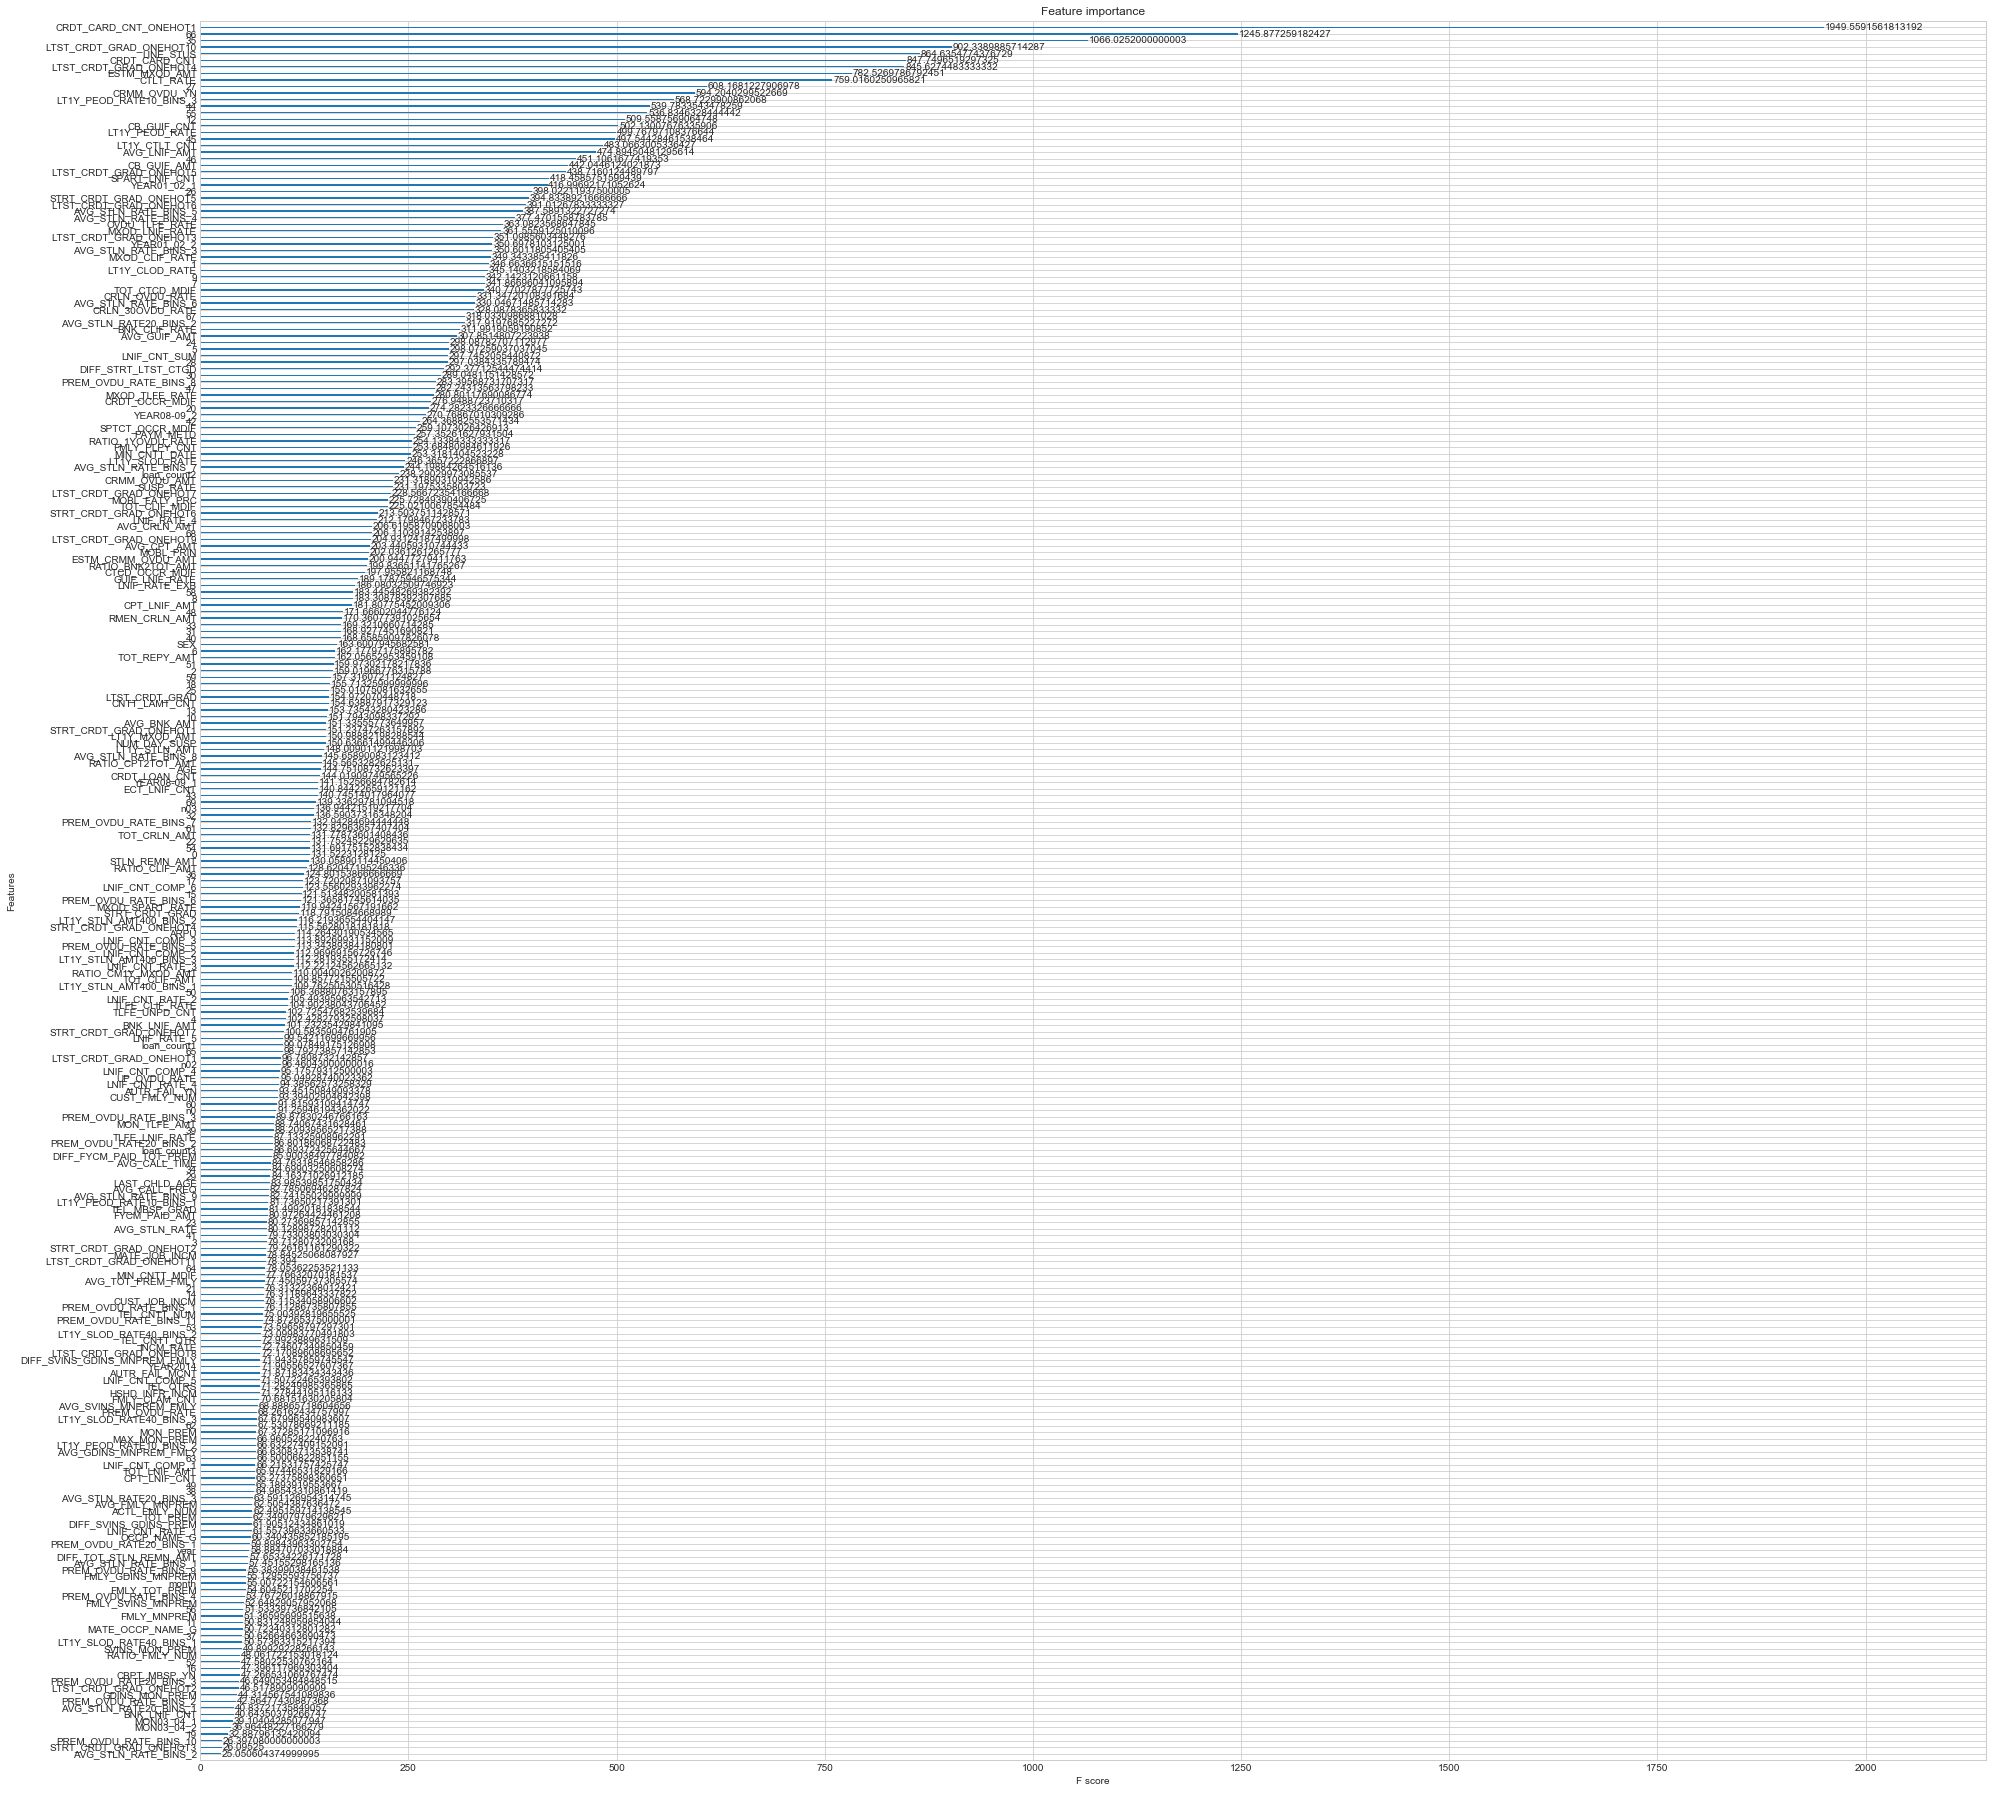

In [15]:
ax = xgb.plot_importance(bst,importance_type="cover")
fig = ax.figure
fig.set_size_inches(32, 32)

In [11]:
from sklearn.metrics import precision_recall_curve

In [12]:
precision, recall, thresholds = precision_recall_curve(Y_val, bst.predict(dtest))
i = np.arange(len(precision[:-2]))# index for df
#f1 : precision과 recall의 조화 평균
roc = pd.DataFrame({'Precision' : pd.Series(precision[:-2], index=i),'recall' : pd.Series(recall[:-2], index = i), 
                    'f1' : pd.Series(((2*precision[:-2]*recall[:-2])/(precision[:-2]+recall[:-2])), index = i), 
                    'thresholds' : pd.Series(thresholds[:-1], index = i)})

In [13]:
roc.loc[roc.f1==roc.f1.max()]

,Precision,f1,recall,thresholds
23871,0.466253,0.492185,0.52117,0.213003
